# Introduction to a Conditional Generative Adversarial Network

## Prerequisites

### Knowledge
- https://arxiv.org/abs/1411.1784

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_datasets as tfds

### Data

In [2]:
# defining some important konstants
z_dim = 100
batch_size = 50
num_classes = 10

# Load the dataset
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Labels for real and fake examples
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

print(X_train.shape, np.min(X_train), np.max(X_train))
print(y_train.shape)

(60000, 28, 28, 1) -1.0 1.0
(60000,)


## CGAN

### Generator

In [3]:
class Generator(tf.keras.Model):
    
    def __init__(self, num_classes, z_dim):
        super(Generator, self).__init__()
        self.model = tf.keras.Sequential([# Reshape input into 7x7x128 tensor via a fully connected layer
                                          tf.keras.layers.Dense(256 * 7 * 7),
                                          tf.keras.layers.Reshape((7, 7,256)),
                                          # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
                                          tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
                                          tf.keras.layers.BatchNormalization(fused=False),
                                          tf.keras.layers.LeakyReLU(alpha=0.2),
                                          # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
                                          tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'),
                                          tf.keras.layers.BatchNormalization(fused=False),
                                          tf.keras.layers.LeakyReLU(alpha=0.2),
                                          # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
                                          tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'),
                                          tf.keras.layers.Activation('tanh')])
        self.label_embedding = tf.keras.layers.Embedding(num_classes, z_dim, input_length=1, dtype=tf.float64)
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, x):
        z_sample, label = x
        label_embedding = self.label_embedding(label)
        flatted_label_embedding = self.flatten(label_embedding)
        joined_representation = tf.math.multiply(z_sample, flatted_label_embedding)
        img = self.model(joined_representation)
        return img

generator = Generator(num_classes, z_dim)

### Discriminator

In [4]:
class Discriminator(tf.keras.Model):
    
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.model = tf.keras.Sequential([# Convolutional layer, from 28x28x1 into 14x14x32 tensor
                                          tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
                                          tf.keras.layers.LeakyReLU(alpha=0.2),
                                          # Convolutional layer, from 14x14x32 into 7x7x64 tensor
                                          tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
                                          tf.keras.layers.BatchNormalization(fused=False),
                                          tf.keras.layers.LeakyReLU(alpha=0.2),
                                          # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
                                          tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
                                          tf.keras.layers.BatchNormalization(fused=False),
                                          tf.keras.layers.LeakyReLU(alpha=0.2),
                                          # Flatten the tensor and apply sigmoid activation function
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(1, activation='sigmoid')])
        self.label_embedding = tf.keras.layers.Embedding(num_classes, np.prod(img_shape), input_length=1, dtype=tf.float64)
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.img_shape = img_shape
        
    def call(self, x):
        img, label = x
        label_embedding = self.label_embedding(label)
        reshaped_label_embedding = tf.reshape(label_embedding, [-1, self.img_shape[0], self.img_shape[1], self.img_shape[2]])
        concatenated = self.concat([img, reshaped_label_embedding])
        prediction = self.model(concatenated)
        return prediction

discriminator = Discriminator(num_classes, (28, 28, 1))

### Training

In [5]:
generator_opt = tf.keras.optimizers.Adam()
discriminator_opt = tf.keras.optimizers.Adam()

When training the generator, you use

In [6]:
@tf.function
def train_discriminator(img_and_label, label):
    with tf.GradientTape() as tape:
        # calculate loss
        prediction = discriminator(img_and_label)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction))
        accuracy = tf.reduce_mean(tf.keras.metrics.binary_accuracy(y_true=label, y_pred=prediction))

        # gradient descent and only update discriminator
        gradient = tape.gradient(loss, discriminator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradient, discriminator.trainable_variables))
    return loss, accuracy

In [7]:
@tf.function
def train_generator(sample_and_label, label):
    with tf.GradientTape() as tape:
        image = generator(sample_and_label)
        prediction = discriminator([image, sample_and_label[1]])
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction))
        # gradient descent and only update generator
        gradients = tape.gradient(loss, generator.trainable_variables)
        generator_opt.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

Iteration 0 d_loss 0.7184702635589544 g_loss 0.6863342644726468 accuracy 0.0


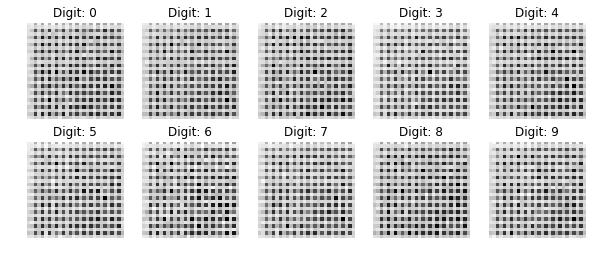

Iteration 2000 d_loss 0.0006694221584597513 g_loss 8.9094727458689 accuracy 1.0


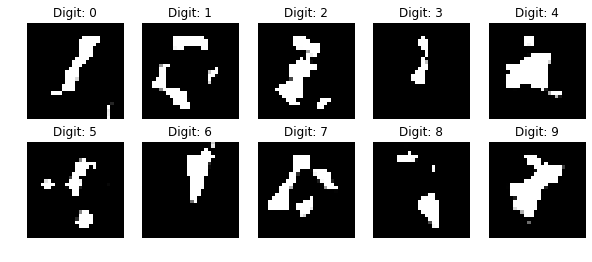

Iteration 4000 d_loss 0.17648908886972342 g_loss 5.554217104309655 accuracy 0.949999988079071


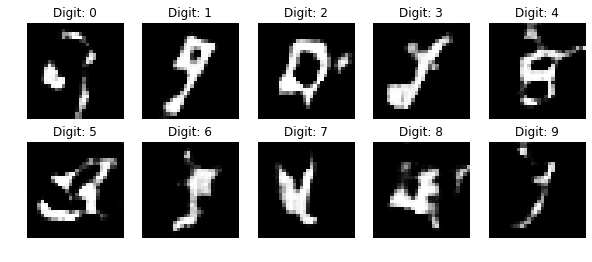

Iteration 6000 d_loss 0.21547514413880636 g_loss 3.7847938480376446 accuracy 0.9399999976158142


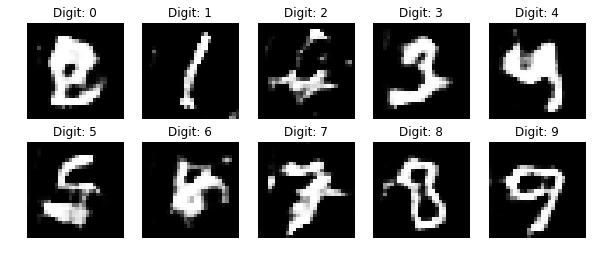

Iteration 8000 d_loss 0.37768603214029506 g_loss 2.1620883897700893 accuracy 0.8299999833106995


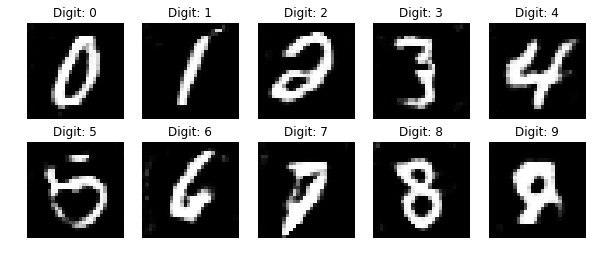

In [8]:
# init lists for losses and accuracies
d_losses, d_accuracies, g_losses = [], [], []

ITERATIONS = 10000
for i in range(ITERATIONS):
    # pick a random sample from the datas
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]    
    
    # Generate a batch of fake images
    z_sample = np.random.normal(0, 1, (batch_size, z_dim))
    gen_image = generator([z_sample, labels])

    # Discriminator loss and train discriminator on fake and real images
    d_loss_real, d_accuracy_real = train_discriminator([imgs, labels], real)
    d_loss_fake, d_accuracy_fake = train_discriminator([gen_image, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_accuracy = 0.5 * np.add(d_accuracy_real, d_accuracy_fake)

    # Generator loss
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1) # get random labels
    g_loss = train_generator([z_sample, labels], real)
    g_loss = g_loss.numpy()

    # visualization
    if i % 2000 == 0:
        print("Iteration", i, "d_loss", d_loss, "g_loss", g_loss, "accuracy", d_accuracy)
        image_grid_rows = 2
        image_grid_columns = 5
        # Sample random noise
        z = np.random.normal(0, 1, 
                  (image_grid_rows * image_grid_columns, z_dim))

        labels = np.arange(0, 10).reshape(-1, 1)
        # Generate images from random noise
        gen_imgs = generator([z, labels])
        # Rescale images to 0-1
        gen_imgs = 0.5 * gen_imgs + 0.5
        # Set image grid
        fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                        figsize=(10,4), sharey=True, sharex=True)
        cnt = 0
        for i in range(image_grid_rows):
            for j in range(image_grid_columns):
                # Output image grid
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                axs[i,j].set_title("Digit: %d" % labels[cnt])
                cnt += 1
        plt.show()
        
        d_losses.append(d_loss)
        d_accuracies.append(d_accuracy)
        g_losses.append(g_loss)

### Visualization

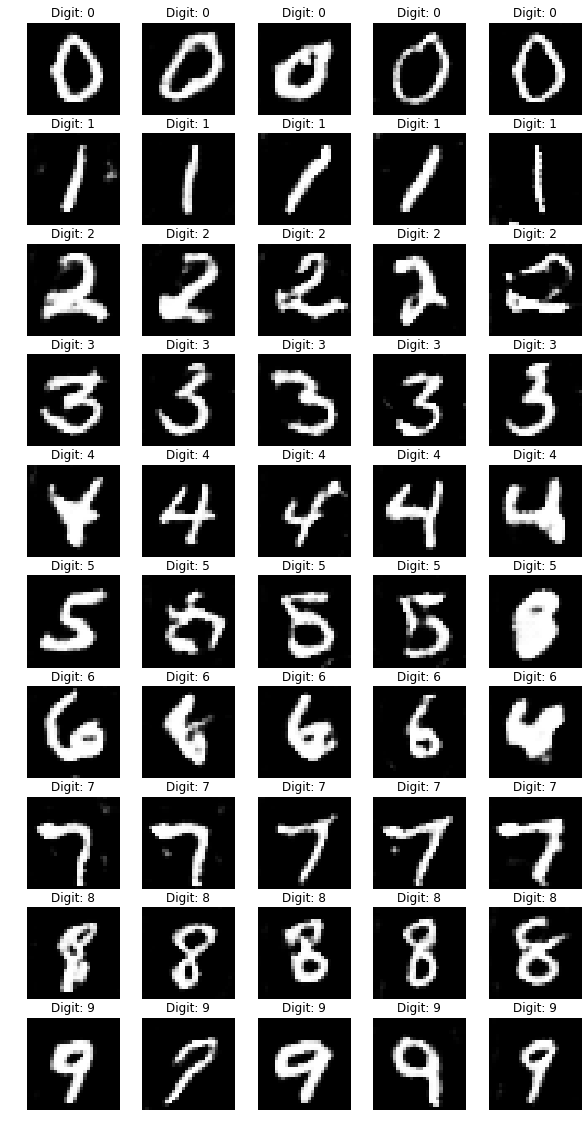

In [9]:
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator([z, labels_to_generate])

# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10, 20), sharey=True, sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        axs[i,j].set_title("Digit: %d" % labels_to_generate[cnt]) ## NEW
        cnt += 1

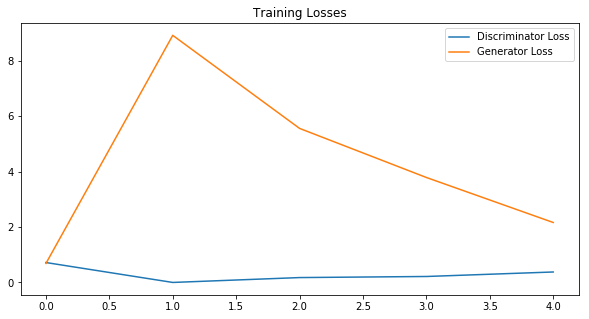

In [10]:
# Plot training losses for Discriminator and Generator
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Training Losses")
plt.legend()

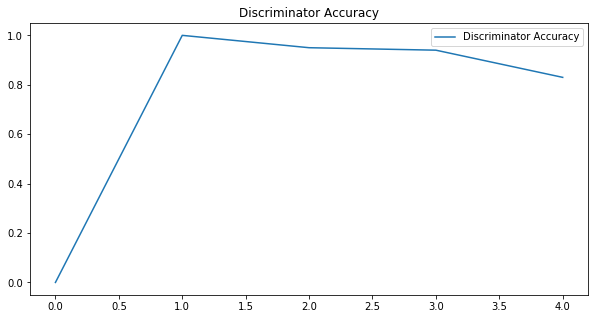

In [11]:
accuracies = np.array(d_accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()